Here we use the `mtgsdk` to load cards from the online database and use their colors to cast spells accordingly

In [1]:
import numpy as np
np.random.seed(19)

In [2]:
%matplotlib inline

In [3]:
import pylab as pl
pl.rcParams['figure.dpi'] = 120

In [4]:
from mtgsdk import Card as QueryDB
import pickle
import csv

In [5]:
import random

class Card():
    
    def __init__(self, name):
        
        try:
            c = QueryDB.where(name='"%s"'%name).array()  # exact name match
            if len(c) == 0:
                print('Couldn\'t find exact match for %s.'%name)
                c = QueryDB.where(name=name).array()  # try without exact match
            c = c[0]
            self.name = c['name']
            self.types = c['types']
            try:
                self.power = c['power']
            except KeyError:
                self.power = None
            try:
                self.tough = c['toughness']
            except KeyError:
                self.tough = None
            try:
                self.cost = {'green':0,
                     'blue':0,
                     'white':0,
                     'red':0,
                     'black':0,
                     'x':0,
                     'colorless':0}
                for cc in c['manaCost'].replace('{', '').replace('}', ''):
                    if cc == 'W':
                        self.cost['white'] += 1
                    elif cc == 'B':
                        self.cost['black'] += 1
                    elif cc == 'G':
                        self.cost['green'] += 1
                    elif cc == 'U':
                        self.cost['blue'] += 1
                    elif cc == 'R':
                        self.cost['red'] += 1
                    elif cc == 'X':
                        self.cost['x'] = 1  # just a number > 0
                    else:
                        self.cost['colorless'] = int(cc)
                        
            except KeyError:
                self.cost = None
            self._card = c

        except IndexError:
            
            print("Couldn't find %s, skipping."%name)
            self.name = name
            self.types = []
            self.power = None
            self.tough = None
            self.cost = None
            self._card = None
        
    def is_type(self, type_string):
        return type_string.lower() in [t.lower() for t in self.types]
    
    def is_land(self):
        return self.is_type('land')
    
    def is_creature(self):
        return self.is_type('creature')
    
    def is_instant(self):
        return self.is_type('instant')
        
    def get_combined_cost(self):
        return np.sum(self.cost)
    
    def __repr__(self):
        return self.name

In [62]:
class Deck():
    
    def __init__(self, name):
        self.name = name
        self._reset([])
        
    def import_names(self, cards):
        for c in cards:
            self.library.append(Card(c))
        random.shuffle(self.library)

    def import_csv(self, filename='decks/white_green.csv'):
        cards = []
        with open(filename, 'r') as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            for row in reader:
                if row[0] == 'Name':
                    continue
                howmany = int(row[-1])
                while howmany>0:
                    cards.append(row[0])
                    howmany -= 1
        self.import_names(cards)
        
    def draw(self, n=1):
        for i in range(n):
            picked = self.library[0]
            self.library = self.library[1:]
            self.hand = np.append(self.hand, picked)
#             print(picked.name)
        return picked
    
    def play(self):
        '''
        - draw a card
        - play a random land if any
        - play a random playable card, given the available mana
        - discard if more then 7 cards in hand
        '''
        # draw a card
        picked = self.draw()
        # play a random land if any
        land = self.land()
        # play a random playable card, given the available mana
        played = self.cast()
        # discard if more then 7 cards in hand
        discarded = self.cleanup()
        return land, picked, played, discarded
    
    def get_all_mana(self):
        '''
        get all available mana from all lands
        '''
        # use all available mana and put it into self.mana
        self._reset_mana()
        for l in self.lands:
            if l.name=='Forest':
                self.mana['green'] += 1
            elif l.name=='Swamp':
                self.mana['black'] += 1
            elif l.name=='Plains':
                self.mana['white'] += 1
            elif l.name=='Mountain':
                self.mana['red'] += 1
            elif l.name=='Island':
                self.mana['blue'] += 1
            else:
                print("Sorry, can't deal with this land yet, adding no mana from %s."%l.name)
    
    def land(self):
        '''
        play a random land
        '''
        yes_no = []
        for h in self.hand:
            yes_no.append(h.is_land())
        try:
            which = np.where(yes_no)[0][0]  # first land in hand
            self.lands.append(self.hand[which])
            self.hand = np.delete(self.hand, which)
            toret = 1
        except IndexError:
#             print "No land in hand. :("
            toret = 0
        return toret
    
    def cast(self):
        '''
        cast a random spell regardless of its type
        '''
        self.get_all_mana()
        which_playable = self.get_playables()
        if sum(which_playable)>0:
            which_to_play = np.random.permutation(np.where(which_playable)[0])[0]
            self.tap_mana(self.hand[which_to_play])
            toret = self.hand[which_to_play]
            self.played.append(toret)
            self.hand = np.delete(self.hand, which_to_play)
        else:
            toret = None
        return toret

    def tap_mana(self, card):
        '''
        decrease the amount of mana necessary to play the given card
        '''
        # useless for now since we only play one card per round
        pass
    
    def cleanup(self):
        if len(self.hand) > 7:
            try:
                which = np.random.choice(np.where([not c.is_land() for c in self.hand])[0])
            except IndexError:
                # they're all lands!
                which = 0
            toret = self.hand[which]
            self.discard(which)
        else:
            toret = None
        for i, card in enumerate(self.played):
            if card.is_type('sorcery') or card.is_type('instant'):
                self.remove(i)
        return toret
    
    def remove(self, i):
        '''
        remove card from self.played and put it into the self.discarded
        '''
        self.discarded.append(self.played[i])
        self.played = np.delete(self.played, i).tolist()
        return
    
    def discard(self, i):
        '''
        put the given card into the self.discarded stack from self.hand
        '''
        self.discarded.append(self.hand[i])
        self.hand = np.delete(self.hand, i)
        return
    
    def is_playable(self, card):
        '''
        check if enough mana is available to play the given card
        (return False for lands since we assume they are played in a different phase)
        '''
        if card.is_land():
            return False
        remainder = self.mana.copy()
        for c, v in card.cost.items():
            if c == 'x' or c == 'colorless':
                continue
            remainder[c] = self.mana[c] - v
        if any(np.r_[list(remainder.values())]<0):
            return False
        remainder['colorless'] -= card.cost['colorless'] - np.sum([np.clip(remainder['green'], 0, np.inf),
                                                                   np.clip(remainder['blue'], 0, np.inf),
                                                                   np.clip(remainder['white'], 0, np.inf),
                                                                   np.clip(remainder['red'], 0, np.inf),
                                                                   np.clip(remainder['black'], 0, np.inf),])
        if remainder['colorless']<0: 
            return False
        if card.cost['x'] > 0 and remainder['colorless'] <= 0:
            return False
        return True
        
    def get_playables(self):
        '''
        check if enough mana is available to play each card in hand and return a boolean list
        '''
        return [self.is_playable(card) for card in self.hand]          
    
    def _reset_mana(self):
        self.mana = {'green':0,
                     'blue':0,
                     'white':0,
                     'red':0,
                     'black':0,
                     'colorless':0}
    
    def _reset(self, library):
        '''
        - set the library
        - shuffle
        - empty hand, lands, discarded
        - reset mana to 0
        '''
        self.library = library
        if len(library)>0:
            random.shuffle(library)
        self.hand = []
        self._reset_mana()
        self.lands = []
        self.discarded = []
        self.played = []
        
    def save(self, filename=None):
        '''
        dumps the library into a binary file
        '''
        if filename is None:
            filename = self.name
        with open(filename, 'wb') as f:
            pickle.dump(self.library, f)
            
    def load(self, filename, name=None):
        '''
        loads the library and resets the deck (see self._reset)
        a new name for the deck can be given
        '''
        with open(filename, 'rb') as f:
            self._reset(pickle.load(f))
        if name is not None:
            deck.name = name
            
    def get_lands(self):
        return [card for card in self.library if card.is_land()]
    
    def get_creatures(self):
        return [card for card in self.library if card.is_type('Creature')]
    
    def get_sorceries(self):
        return [card for card in self.library if card.is_type('Sorcery')]
    
    def get_instants(self):
        return [card for card in self.library if card.is_type('Instant')]
    
    def get_enchantments(self):
        return [card for card in self.library if card.is_type('Enchantment')]
    
    def get_stats_card_types(self):
        return np.r_[[len(self.get_lands()),
                      len(self.get_creatures()),
                      len(self.get_sorceries()),
                      len(self.get_instants()),
                      len(self.get_enchantments())]]
    
    def get_

In [63]:
%%time
deck = Deck(name='white_green')
# deck.import_csv('decks/white_green.csv')
# deck.save('decks/white_green.dck')

CPU times: user 22 µs, sys: 1 µs, total: 23 µs
Wall time: 29.6 µs


In [64]:
deck.load('decks/white_green.dck')

In [56]:
deck.get_stats_card_types()

array([20, 22,  3,  9,  6])

In [17]:
# %%time
# deck.import_csv('decks/green_nissa_duel_deck.csv')
# deck.save('decks/green_nissa.dck')

CPU times: user 1.27 s, sys: 41.4 ms, total: 1.31 s
Wall time: 10.6 s


In [19]:
# %%time
# deck.import_csv('decks/black_ob_nixilis_duel_deck.csv')
# deck.save('decks/black_ob_nixilis.dck')

CPU times: user 1.09 s, sys: 63.4 ms, total: 1.15 s
Wall time: 9.68 s


In [8]:
%%time
deck.import_csv('decks/blue_black.csv')
# Problems with 'Deja vu' ...
# which = np.where(['Deja' in c.name for c in deck.library])[0][0]
# deck.library[which].cost = {'black': 1,
#  'blue': 1,
#  'colorless': 2,
#  'green': 0,
#  'red': 0,
#  'white': 0,
#  'x': 0}
deck.save('decks/blue_black.dck')

CPU times: user 1.19 s, sys: 63.5 ms, total: 1.26 s
Wall time: 25.2 s


In [9]:
%%time
deck.import_csv('decks/red.csv')
deck.save('decks/red.dck')

CPU times: user 1.22 s, sys: 84 ms, total: 1.3 s
Wall time: 20.8 s


In [65]:
deck = Deck(name='white_green')
deck.load('decks/white_green.dck')
deck.draw(7)
print(['%s'%c for c in deck.hand])
lands = [0]
hands = [len(deck.hand)]
for i in range(10):    
    print("----")
    l, draw, played, discarded = deck.play()
    print("Lands\t", deck.lands)
    print("Pick\t", draw, draw.cost)
    print("Play\t", played, played.cost if played is not None else None)
    print("Discard\t", discarded, discarded.cost if discarded is not None else None)
    print('Hand\t', ['%s'%c for c in deck.hand])
    lands.append(deck.lands)
    hands.append(len(deck.hand))

['Forest', 'Craw Wurm', 'Loxodon Anchorite', 'Plains', 'Plains', 'Forest', 'Plains']
----
Lands	 [Forest]
Pick	 Desert Twister {'green': 2, 'blue': 0, 'white': 0, 'red': 0, 'black': 0, 'x': 0, 'colorless': 4}
Play	 None None
Discard	 None None
Hand	 ['Craw Wurm', 'Loxodon Anchorite', 'Plains', 'Plains', 'Forest', 'Plains', 'Desert Twister']
----
Lands	 [Forest, Plains]
Pick	 Plains None
Play	 None None
Discard	 None None
Hand	 ['Craw Wurm', 'Loxodon Anchorite', 'Plains', 'Forest', 'Plains', 'Desert Twister', 'Plains']
----
Lands	 [Forest, Plains, Plains]
Pick	 Alaborn Zealot {'green': 0, 'blue': 0, 'white': 1, 'red': 0, 'black': 0, 'x': 0, 'colorless': 0}
Play	 Alaborn Zealot {'green': 0, 'blue': 0, 'white': 1, 'red': 0, 'black': 0, 'x': 0, 'colorless': 0}
Discard	 None None
Hand	 ['Craw Wurm', 'Loxodon Anchorite', 'Forest', 'Plains', 'Desert Twister', 'Plains']
----
Lands	 [Forest, Plains, Plains, Forest]
Pick	 Temple Acolyte {'green': 0, 'blue': 0, 'white': 1, 'red': 0, 'black': 0, '

In [66]:
deck.played

[Alaborn Zealot, Temple Acolyte, Loxodon Anchorite, Craw Wurm]

Now we simulate a number of such runs. First we encapsulate the above into the `simulate` function.

In [11]:
def simulate(deck, filename, n=100, n_rounds=20):
    hh = []
    ll = []
    for i in range(n):

        deck.load(filename)
        deck.draw(7)
        lands = [0]
        hands = [len(deck.hand)]
        for i in range(n_rounds):    
            l, draw, played, discarded = deck.play()
            lands.append(len(deck.lands))
            hands.append(len(deck.hand))

        hh.append(hands)
        ll.append(lands)

    hh = np.r_[hh]
    ll = np.r_[ll]
    
    return hh, ll

Then we define 3 decks, red, black and green, and we simulate them.

In [20]:
hh_r, ll_r = simulate(deck, 'decks/green_nissa.dck', n_rounds=30)
hh_k, ll_k = simulate(deck, 'decks/black_ob_nixilis.dck', n_rounds=30)
hh_g, ll_g = simulate(deck, 'decks/white_green.dck', n_rounds=30)

Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with th

Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no man

Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with th

Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Treetop Village.
Sorry, can't deal with this land yet, adding no mana from Treetop Village.
Sorry, can't deal with this land yet, adding no mana from Treetop Village.
Sorry, can't deal with this land yet, adding no mana from Treetop Village.
Sorry, can't deal with this land yet, adding no mana from Treetop Village.
Sorry, can't deal with this land yet, adding no mana from Treetop Village.
Sorry, can't deal with this land yet, adding no mana from Treetop Village.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Treetop Village.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Treetop Village.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this lan

Sorry, can't deal with this land yet, adding no mana from Mosswort Bridge.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Mosswort Bridge.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Mosswort Bridge.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Mosswort Bridge.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Mosswort Bridge.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Mosswort Bridge.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this

Sorry, can't deal with this land yet, adding no mana from Treetop Village.
Sorry, can't deal with this land yet, adding no mana from Treetop Village.
Sorry, can't deal with this land yet, adding no mana from Treetop Village.
Sorry, can't deal with this land yet, adding no mana from Treetop Village.
Sorry, can't deal with this land yet, adding no mana from Treetop Village.
Sorry, can't deal with this land yet, adding no mana from Treetop Village.
Sorry, can't deal with this land yet, adding no mana from Treetop Village.
Sorry, can't deal with this land yet, adding no mana from Treetop Village.
Sorry, can't deal with this land yet, adding no mana from Treetop Village.
Sorry, can't deal with this land yet, adding no mana from Treetop Village.
Sorry, can't deal with this land yet, adding no mana from Treetop Village.
Sorry, can't deal with this land yet, adding no mana from Treetop Village.
Sorry, can't deal with this land yet, adding no mana from Treetop Village.
Sorry, can't deal with th

Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no man

Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with th

Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't de

Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Treetop Village.
S

Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with th

Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't 

Sorry, can't deal with this land yet, adding no mana from Mosswort Bridge.
Sorry, can't deal with this land yet, adding no mana from Mosswort Bridge.
Sorry, can't deal with this land yet, adding no mana from Mosswort Bridge.
Sorry, can't deal with this land yet, adding no mana from Mosswort Bridge.
Sorry, can't deal with this land yet, adding no mana from Mosswort Bridge.
Sorry, can't deal with this land yet, adding no mana from Mosswort Bridge.
Sorry, can't deal with this land yet, adding no mana from Mosswort Bridge.
Sorry, can't deal with this land yet, adding no mana from Mosswort Bridge.
Sorry, can't deal with this land yet, adding no mana from Mosswort Bridge.
Sorry, can't deal with this land yet, adding no mana from Mosswort Bridge.
Sorry, can't deal with this land yet, adding no mana from Mosswort Bridge.
Sorry, can't deal with this land yet, adding no mana from Mosswort Bridge.
Sorry, can't deal with this land yet, adding no mana from Mosswort Bridge.
Sorry, can't deal with th

Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.

Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Leechridden Swamp.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry

Sorry, can't deal with this land yet, adding no mana from Treetop Village.
Sorry, can't deal with this land yet, adding no mana from Treetop Village.
Sorry, can't deal with this land yet, adding no mana from Mosswort Bridge.
Sorry, can't deal with this land yet, adding no mana from Treetop Village.
Sorry, can't deal with this land yet, adding no mana from Mosswort Bridge.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, add

Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Fertile Thicket.
Sorry, can't deal with this land yet, adding no mana from Treetop Village.
Sorry, can't deal with this land yet, adding no mana from Treetop Village.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Treetop Village.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Treetop Village.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land yet, adding no mana from Treetop Village.
Sorry, can't deal with this land yet, adding no mana from Khalni Garden.
Sorry, can't deal with this land 

Finally, we plot the average number of cards in hand in each round. Rapid decks tend to have a steeper curve. Slower decks tend to have a higher curve and only until later rounds the number of cards in hand start to decline.

Text(0.5,1,"# Lands in own's territory")

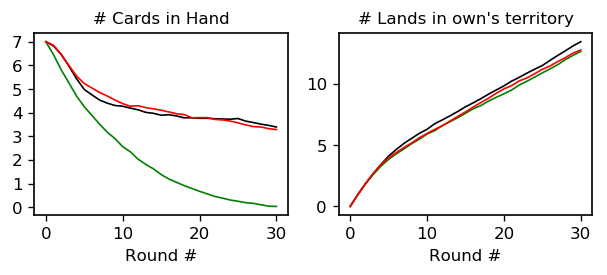

In [21]:
fig, axs = pl.subplots(1, 2, figsize=(6, 2))
axs[0].plot(hh_k.mean(0), color='k', lw=1)
axs[0].plot(hh_g.mean(0), color='g', lw=1)
axs[0].plot(hh_r.mean(0), color='r', lw=1)

axs[0].set_yticks(range(8))

axs[0].set_xlabel('Round #')
axs[0].set_title('# Cards in Hand')

axs[1].plot(ll_k.mean(0), color='k', lw=1)
axs[1].plot(ll_g.mean(0), color='g', lw=1)
axs[1].plot(ll_r.mean(0), color='r', lw=1)

axs[1].set_xlabel('Round #')
axs[1].set_title('# Lands in own\'s territory')